--> Installing required packages and tools...
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tshark is already the newest version (3.6.2-2).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
✅ Environment setup complete.

--> Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

--- Defining Models and Attack Files for Validation ---

--> Processing PCAP file: sqli_attack_capture.pcapng...
    - Found 109 unique flows.

--> Processing PCAP file: sqli_search_attack.pcapng...
    - Found 319 unique flows.

--> Processing PCAP file: slow_rate_attack.pcapng...
    - Found 205 unique flows.

      Testing Model: XGBoost


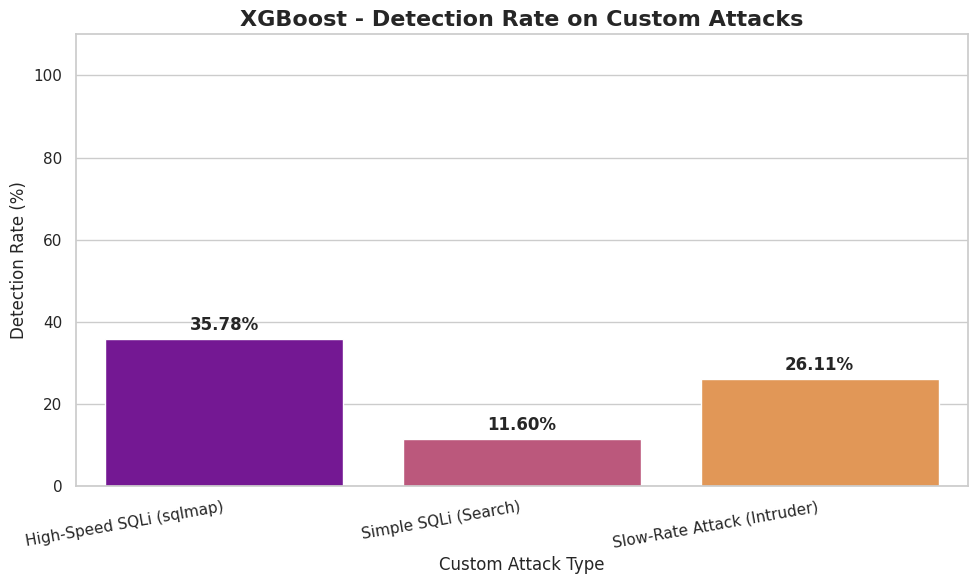


      Testing Model: RandomForest


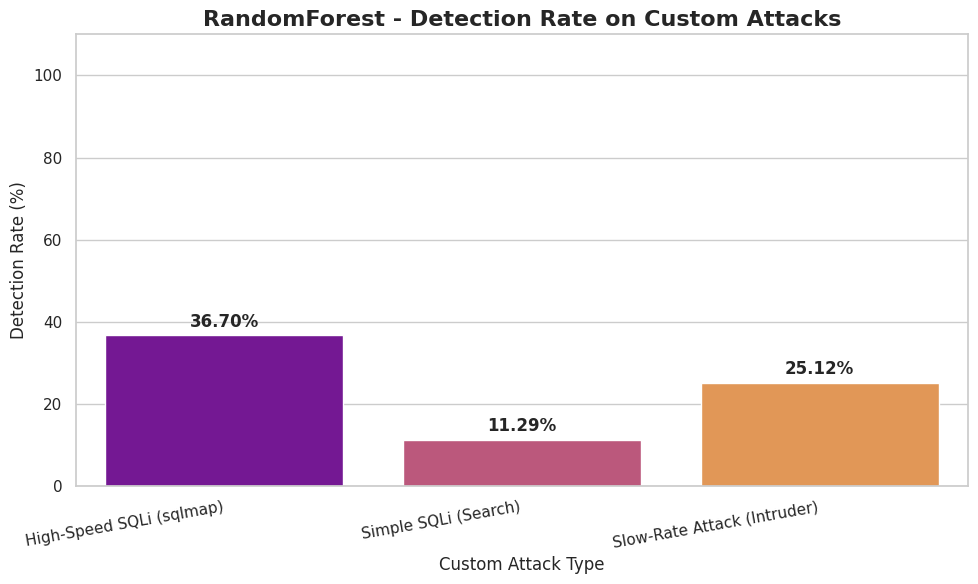


      Testing Model: LightGBM


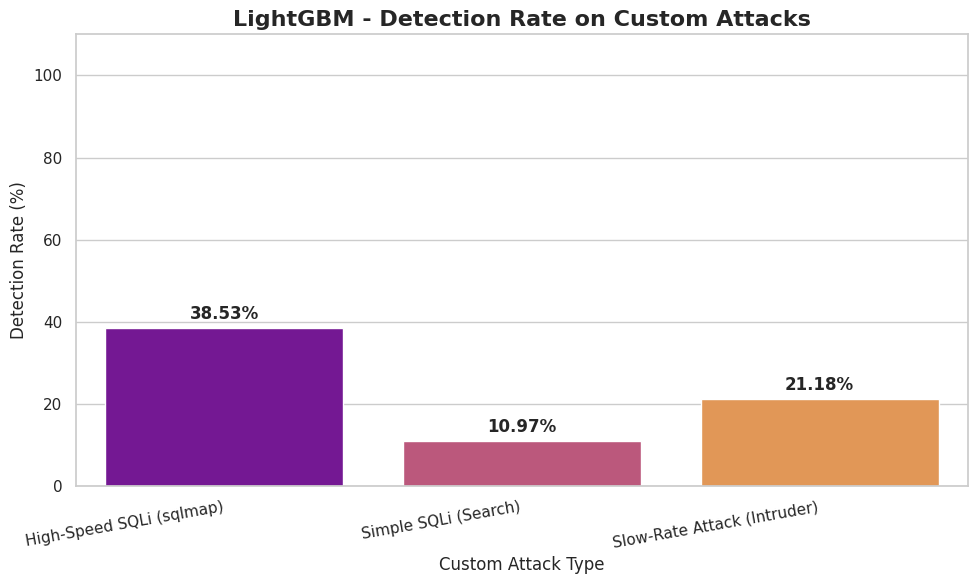


      Testing Model: CatBoost


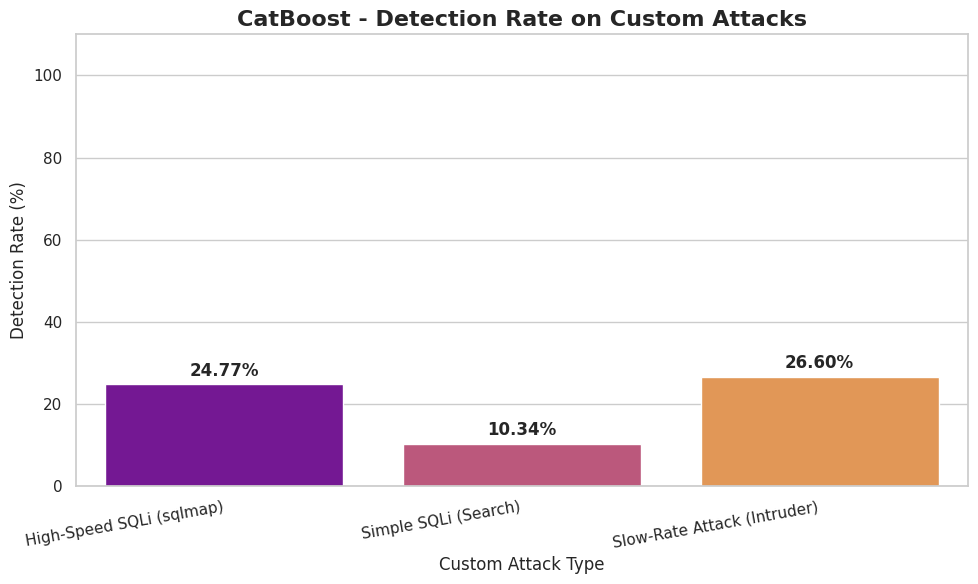


      Testing Model: DecisionTree


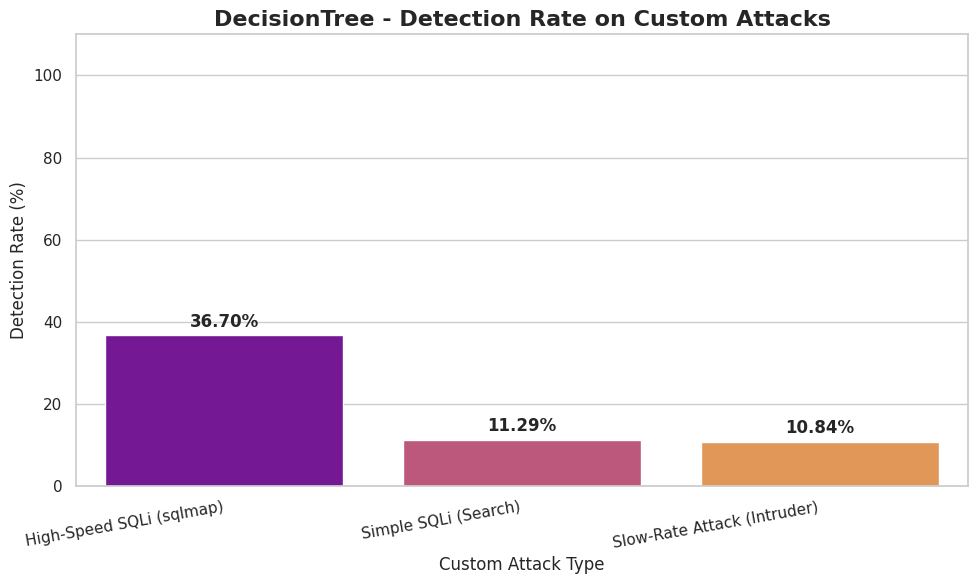


      Testing Model: KNN


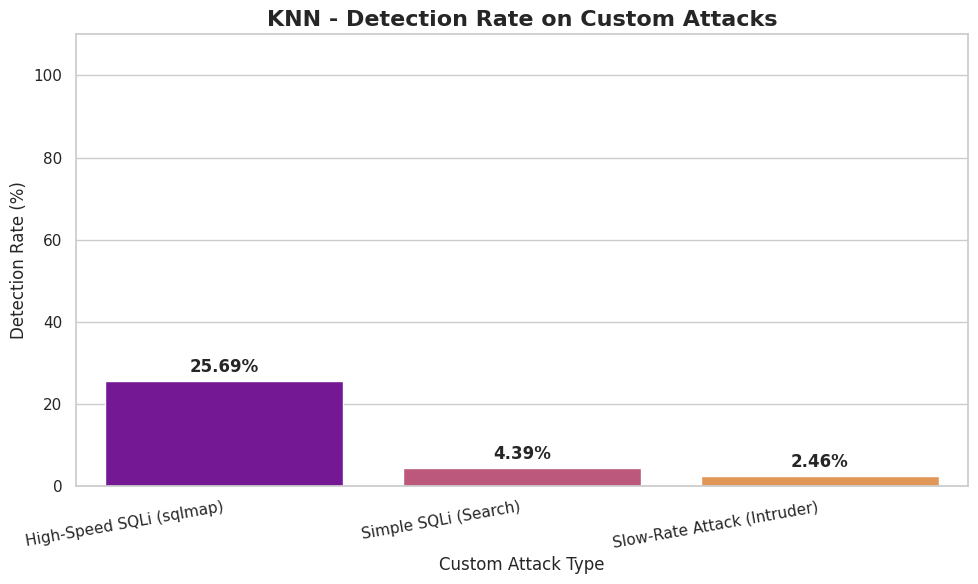


      COMPREHENSIVE REAL-WORLD VALIDATION SUMMARY

--- Summary Heatmap ---


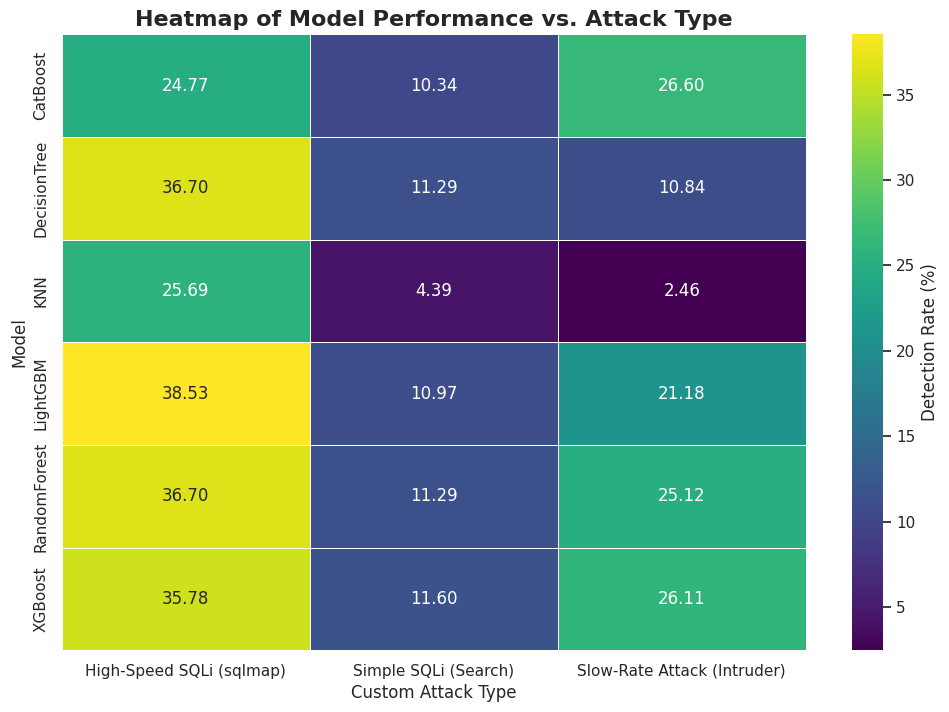


--- Comprehensive Bar Chart ---


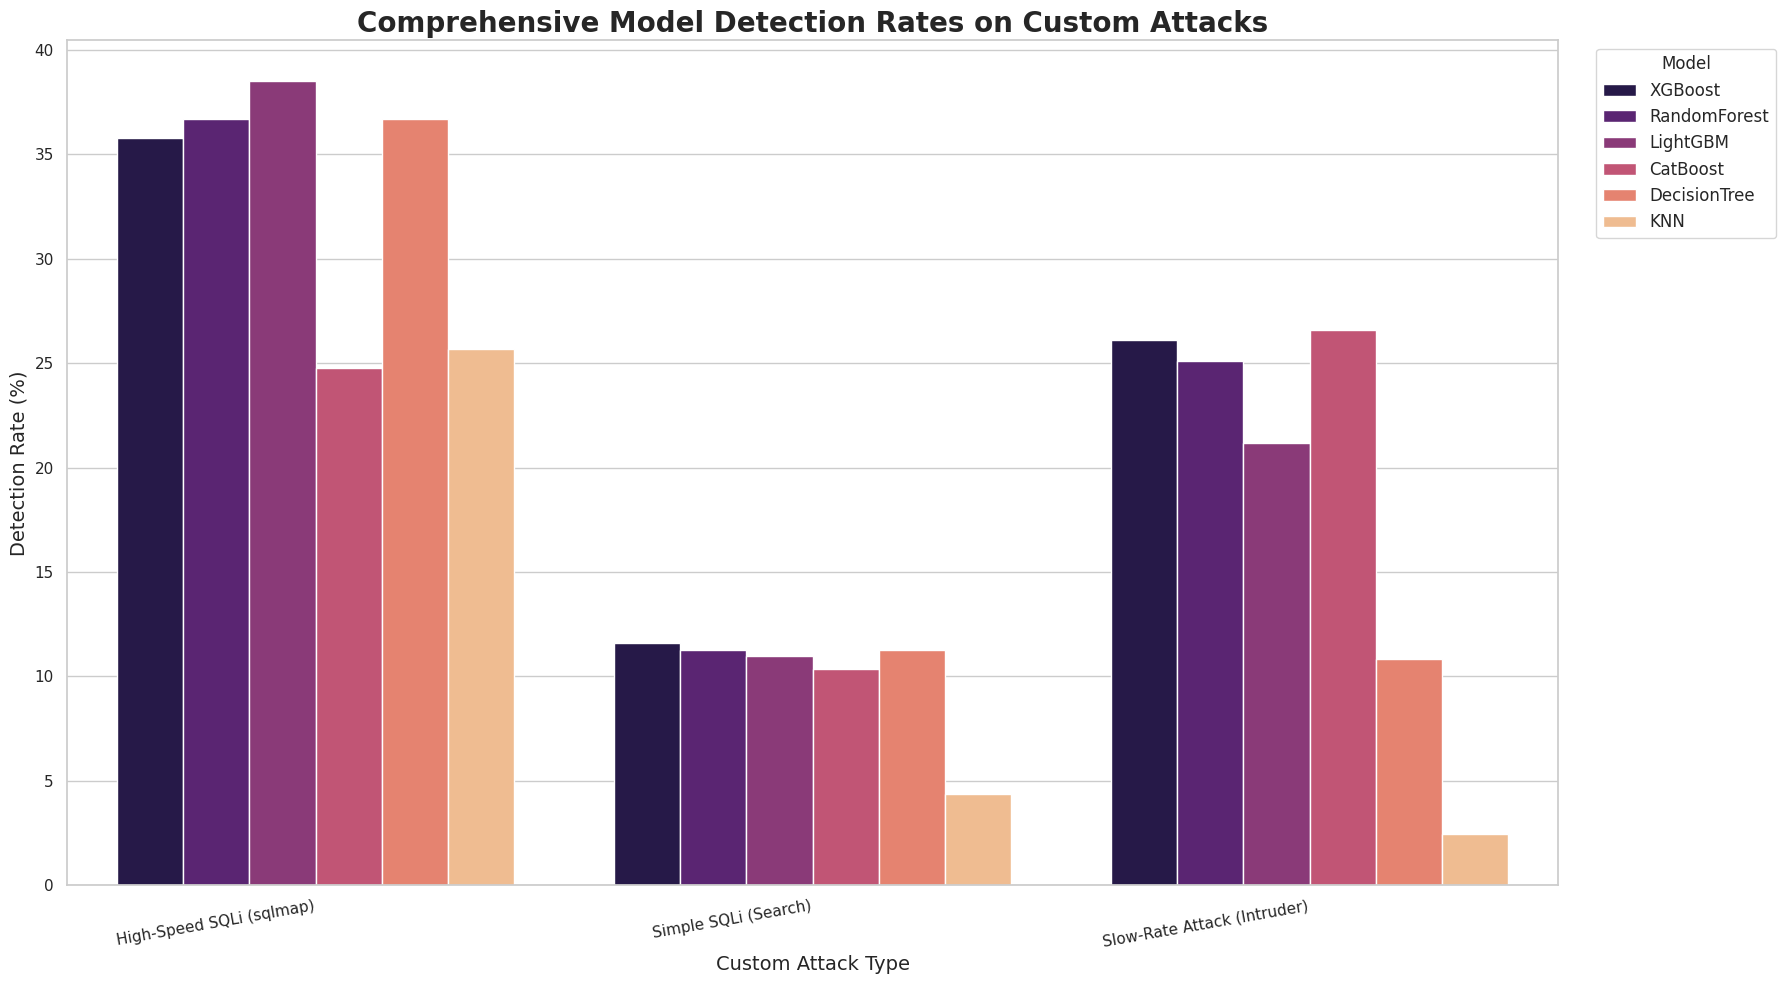


--- Performance Distribution Swarm Plot ---


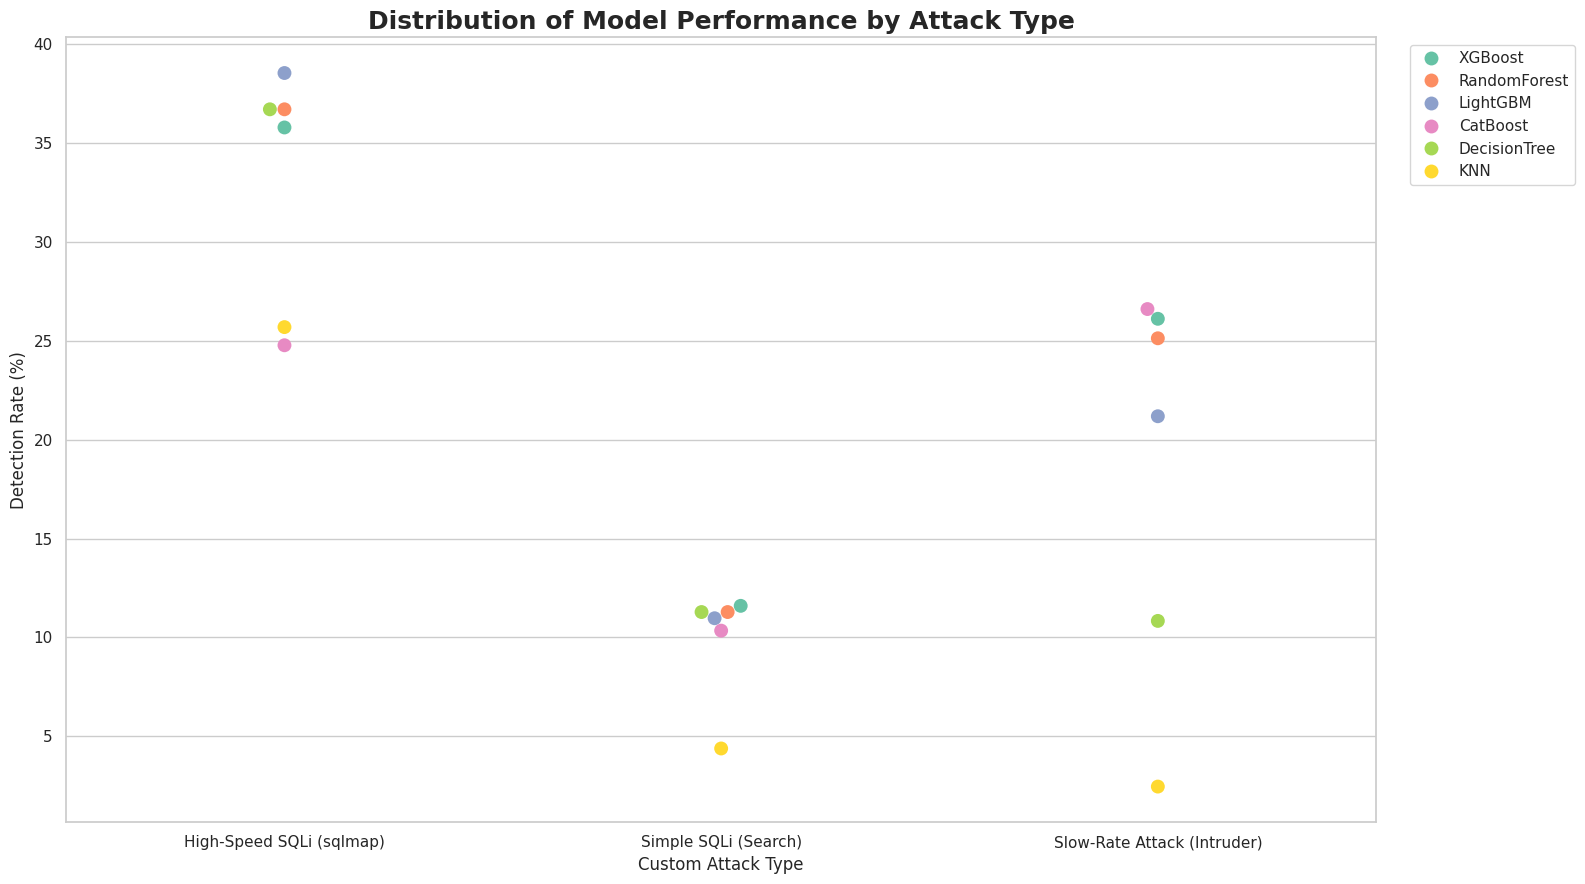


           Final Bake-Off Verdict
--- Average Detection Rate Across All Custom Attacks ---


,Detection Rate (%)
Model,
XGBoost,24.50%
RandomForest,24.37%
LightGBM,23.56%
CatBoost,20.57%
DecisionTree,19.61%
KNN,10.85%



🏆 Overall Real-World Champion: XGBoost
This model demonstrated the best overall performance, achieving the highest average detection rate of 24.50% across all three custom attack scenarios.


In [4]:
# --- 1. Setup Environment ---
print("--> Installing required packages and tools...")
# Install all necessary libraries for the bake-off
!pip install -q pyshark nest_asyncio scikit-learn xgboost lightgbm catboost
# Install the TShark application
!apt-get install -y tshark
print("✅ Environment setup complete.")

# --- 2. Import Libraries and Setup ---
import pandas as pd
import numpy as np
import joblib
import pyshark
from collections import defaultdict
import datetime
import nest_asyncio
import os
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import warnings
warnings.simplefilter(action='ignore')

# Mount Google Drive and apply pyshark patch
print("\n--> Mounting Google Drive...")
drive.mount('/content/drive')
nest_asyncio.apply()

# --- 3. Define All Models and PCAP Files to Test ---
print("\n--- Defining Models and Attack Files for Validation ---")
base_path = '/content/drive/MyDrive/CSE498R/'
# REMOVED: LogisticRegression from the list
models_to_test = {
    "XGBoost": os.path.join(base_path, 'Colab_Output/validation_model_XGBoost/'),
    "RandomForest": os.path.join(base_path, 'Colab_Output/validation_model_RandomForest/'),
    "LightGBM": os.path.join(base_path, 'Colab_Output/validation_model_LightGBM/'),
    "CatBoost": os.path.join(base_path, 'Colab_Output/validation_model_CatBoost/'),
    "DecisionTree": os.path.join(base_path, 'Colab_Output/validation_model_DecisionTree/'),
    "KNN": os.path.join(base_path, 'Colab_Output/validation_model_KNN/')
}
pcap_files = {
    "High-Speed SQLi (sqlmap)": os.path.join(base_path, 'sqli_attack_capture.pcapng'),
    "Simple SQLi (Search)": os.path.join(base_path, 'sqli_search_attack.pcapng'),
    "Slow-Rate Attack (Intruder)": os.path.join(base_path, 'slow_rate_attack.pcapng')
}

# --- 4. Feature Extraction Function ---
def extract_flow_features(pcap_file, validation_features):
    print(f"\n--> Processing PCAP file: {os.path.basename(pcap_file)}...")
    flows = defaultdict(list)
    try:
        cap = pyshark.FileCapture(pcap_file, display_filter="ip")
        for packet in cap:
            try:
                flow_key = tuple(sorted((packet.ip.src, packet.ip.dst, packet[packet.transport_layer].srcport,
                                         packet[packet.transport_layer].dstport, packet.transport_layer)))
                flows[flow_key].append(packet)
            except (AttributeError, KeyError): continue
        cap.close()
    except Exception as e:
        print(f"    - ❌ Error processing {os.path.basename(pcap_file)}: {e}")
        return pd.DataFrame()

    print(f"    - Found {len(flows)} unique flows.")
    flow_data = []
    for key, packets in flows.items():
        if len(packets) < 2: continue
        packets.sort(key=lambda p: float(p.sniff_timestamp))
        flow_duration = (packets[-1].sniff_time - packets[0].sniff_time).total_seconds() * 1e6
        fwd_packets = [p for p in packets if p.ip.src == packets[0].ip.src]
        bwd_packets = [p for p in packets if p.ip.src != packets[0].ip.src]
        flow_data.append([flow_duration, len(fwd_packets), len(bwd_packets),
                          sum(int(p.length) for p in fwd_packets), sum(int(p.length) for p in bwd_packets)])
    return pd.DataFrame(flow_data, columns=validation_features)

# --- 5. Run Full Validation Suite & Generate Individual Plots ---
all_results = []
pcap_dataframes = {}
try:
    temp_features = joblib.load(os.path.join(list(models_to_test.values())[0], 'validation_features.joblib'))
    for name, path in pcap_files.items():
        if os.path.exists(path):
            pcap_dataframes[name] = extract_flow_features(path, temp_features)
        else:
            print(f"⚠️  Warning: File not found, skipping: {path}")
except Exception as e:
    print(f"❌ Could not load feature list to process PCAPs. Error: {e}")

for model_name, model_dir in models_to_test.items():
    print(f"\n" + "="*50)
    print(f"      Testing Model: {model_name}")
    print("="*50)
    model_specific_results = []
    try:
        model = joblib.load(os.path.join(model_dir, 'validation_model.joblib'))
        if os.path.exists(os.path.join(model_dir, 'validation_scaler.joblib')):
             scaler = joblib.load(os.path.join(model_dir, 'validation_scaler.joblib'))
        else:
             scaler = model.named_steps['scaler']
        features = joblib.load(os.path.join(model_dir, 'validation_features.joblib'))

        for attack_name, attack_df in pcap_dataframes.items():
            if attack_df is not None and not attack_df.empty:
                X_custom_scaled = scaler.transform(attack_df)
                predictions = model.predict(X_custom_scaled)
                detection_rate = (np.sum(predictions) / len(predictions)) * 100 if len(predictions) > 0 else 0

                result_entry = {'Model': model_name, 'Attack Type': attack_name, 'Detection Rate (%)': detection_rate}
                all_results.append(result_entry)
                model_specific_results.append(result_entry)
            else:
                all_results.append({'Model': model_name, 'Attack Type': attack_name, 'Detection Rate (%)': 0})
        if model_specific_results:
            model_df = pd.DataFrame(model_specific_results)
            plt.figure(figsize=(10, 6))
            ax_model = sns.barplot(x='Attack Type', y='Detection Rate (%)', data=model_df, palette='plasma')
            ax_model.set_title(f'{model_name} - Detection Rate on Custom Attacks', fontsize=16, weight='bold')
            ax_model.set_xlabel('Custom Attack Type', fontsize=12)
            ax_model.set_ylabel('Detection Rate (%)', fontsize=12)
            ax_model.set_ylim(0, 110)
            for p in ax_model.patches:
                ax_model.annotate(f"{p.get_height():.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                                  ha='center', va='center', xytext=(0, 10), textcoords='offset points', weight='bold')
            plt.xticks(rotation=10, ha="right")
            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"    - ❌ Could not test {model_name}. Error: {e}")

# --- 6. Display and Visualize the Final Comprehensive Results ---
print("\n" + "="*60)
print("      COMPREHENSIVE REAL-WORLD VALIDATION SUMMARY")
print("="*60)

if all_results:
    results_df = pd.DataFrame(all_results)
    # Pivot for the heatmap
    heatmap_data = results_df.pivot(index='Model', columns='Attack Type', values='Detection Rate (%)')

    print("\n--- Summary Heatmap ---")
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="viridis", linewidths=.5, cbar_kws={'label': 'Detection Rate (%)'})
    plt.title('Heatmap of Model Performance vs. Attack Type', fontsize=16, weight='bold')
    plt.ylabel('Model', fontsize=12)
    plt.xlabel('Custom Attack Type', fontsize=12)
    plt.show()

    print("\n--- Comprehensive Bar Chart ---")
    plt.figure(figsize=(18, 10))
    sns.set_theme(style="whitegrid")
    ax = sns.barplot(x='Attack Type', y='Detection Rate (%)', hue='Model', data=results_df, palette='magma')
    ax.set_title('Comprehensive Model Detection Rates on Custom Attacks', fontsize=20, weight='bold')
    ax.set_xlabel('Custom Attack Type', fontsize=14)
    ax.set_ylabel('Detection Rate (%)', fontsize=14)
    plt.xticks(rotation=10, ha="right")
    plt.legend(title='Model', fontsize='12', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    print("\n--- Performance Distribution Swarm Plot ---")
    plt.figure(figsize=(16, 9))
    sns.swarmplot(x='Attack Type', y='Detection Rate (%)', hue='Model', data=results_df, size=10, palette='Set2')
    plt.title('Distribution of Model Performance by Attack Type', fontsize=18, weight='bold')
    plt.xlabel('Custom Attack Type', fontsize=12)
    plt.ylabel('Detection Rate (%)', fontsize=12)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # --- 7. Rank and Choose the Best Performing Model ---
    print("\n" + "="*50)
    print("           Final Bake-Off Verdict")
    print("="*50)

    average_performance = results_df.groupby('Model')['Detection Rate (%)'].mean().sort_values(ascending=False)
    print("--- Average Detection Rate Across All Custom Attacks ---")
    display(average_performance.to_frame().style.format('{:.2f}%'))

    champion_model_name = average_performance.index[0]
    champion_avg_rate = average_performance.iloc[0]

    print(f"\n🏆 Overall Real-World Champion: {champion_model_name}")
    print(f"This model demonstrated the best overall performance, achieving the highest average detection rate of {champion_avg_rate:.2f}% across all three custom attack scenarios.")
else:
    print("No results were generated due to errors in processing or model loading.")